In [8]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.visualization import plot_bloch_multivector
backend = Aer.get_backend('statevector_simulator')

In [9]:
## Parametros de la red de copiado
theta1 = np.arccos(1.0/np.sqrt(5))
theta2 = np.arccos(np.sqrt(5)/3)
theta3 = np.arccos(2/np.sqrt(5))

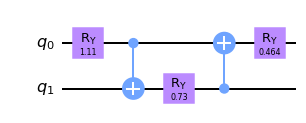

In [21]:
## Demostracion de la fase de preparacion
prep = QuantumCircuit(2)
## Aplicamos rotacion theta1
prep.ry(theta1,0)
## Aplicamos CNOT
prep.cx(0,1)
## Aplicamos rotacion theta2
prep.ry(theta2,1)
## Aplicamos CNOT
prep.cx(1,0)
## Aplicamos rotacion theta3
prep.ry(theta3,0)
## Dibujamos el circuito
prep.draw(output='mpl')

In [20]:
## Simulamos el estado final
PHI = execute(prep,backend).result().get_statevector()
## Imprimimos el resultado final
print(PHI)

[0.81649658+0.j 0.        +0.j 0.40824829+0.j 0.40824829+0.j]


In [28]:
paso_prep = prep.to_gate()
paso_prep.name = 'preparacion'

In [56]:
## Circuito de copiado
MaquinaCopiado = QuantumCircuit(3,1)

In [57]:
## Cagamos un estado inicial arbitrario
theta = np.pi/3.5
phi = np.pi/2.7
estado_a_copiar = np.array([
    np.cos(theta),
    np.exp(1j*np.pi)*np.sin(theta)
])
MaquinaCopiado.initialize(estado_a_copiar,0)

In [58]:
## Incluimos la fase de preparacion
MaquinaCopiado.append(paso_prep,[1,2])
## Colocamos una barrera por claridad
MaquinaCopiado.barrier()

In [59]:
## Incluimos la fase de copiado
MaquinaCopiado.cx(0,1)
MaquinaCopiado.cx(0,2)
MaquinaCopiado.cx(1,0)
MaquinaCopiado.cx(2,0)

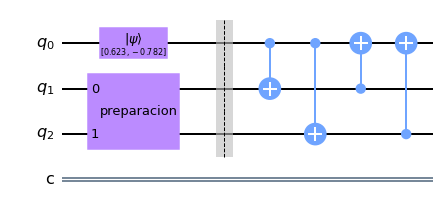

In [60]:
## Dibujamos circuito
MaquinaCopiado.draw(output='mpl')

In [61]:
from qiskit.aqua.utils import get_subsystem_density_matrix

In [62]:
## Ejecutamos y simulamos el circuito
estado_final_registro = execute(MaquinaCopiado,backend).result().get_statevector()
## Imprimimos matriz densidad reducida primer qubit
rho0 = get_subsystem_density_matrix(estado_final_registro,[1,2])
print(rho0)

[[ 0.42582636+0.00000000e+00j -0.32497597-3.97980782e-17j]
 [-0.32497597+3.97980782e-17j  0.57417364+0.00000000e+00j]]


In [63]:
## Imprimimos matriz densidad reducida segundo qubit
rho0 = get_subsystem_density_matrix(estado_final_registro,[0,2])
print(rho0)

[[ 0.42582636+0.00000000e+00j -0.32497597-3.97980782e-17j]
 [-0.32497597+3.97980782e-17j  0.57417364+0.00000000e+00j]]
